In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [5]:
df = pd.read_csv('titanic-2.csv')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss


# EDA

In [6]:
# df.dtypes
df.shape

(891, 13)

In [9]:
""" localizamos duplicados """

df.duplicated().sum()

0

In [10]:
""" localizamos nulos """

df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

In [21]:
""" imputers """

from sklearn.impute import SimpleImputer, KNNImputer

imputer1 = SimpleImputer(strategy='median')

X = df[['Age']]
X_imputed = imputer1.fit_transform(X)

# X_imputed[-5:]
# X[-5:]

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(X)
plt.subplot(1,2,2)
sns.histplot(X_imputed)
plt.show()

In [31]:
df2 = df.copy()

imputer2 = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

key_cols = ['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']
X = df[key_cols]
df2[key_cols] = imputer2.fit_transform(X) 

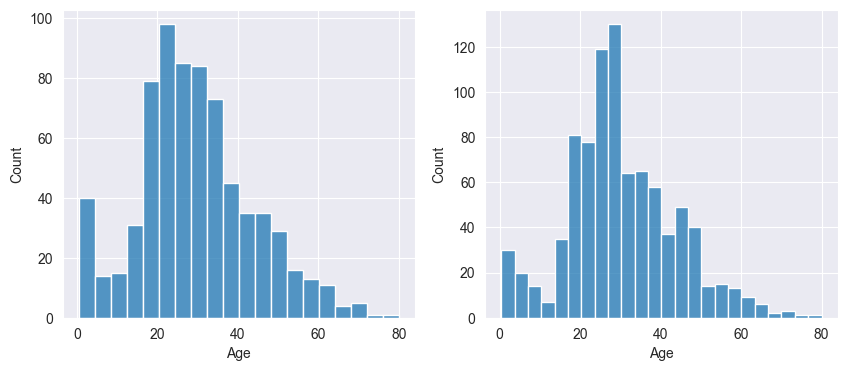

In [32]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='Age')
plt.subplot(1,2,2)
sns.histplot(data=df2, x='Age')
plt.show()

In [37]:
# imputer en pandas

df3 = df.copy()
median = np.nanmedian(df.Age)
print(median)
df3['Age'].fillna(median)

28.0


0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    28.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [40]:
# Embarked

df4 = df.copy()
df4 = df4[~df4.Embarked.isnull()]

print(len(df))
print(len(df4))

891
889


In [42]:
# crear variable hasCabin

df4.fillna(0, inplace=True)
df4['hasCabin'] = df4.Cabin.apply(lambda x: 0 if x==0 else 1)

In [46]:
""" Exploracion de categoricas """

num_cols = ['Age','Fare']
cat_cols = ['Pclass','Sex','SibSp','Parch','Embarked','Title','hasCabin']

In [52]:
""" Juntamos categorias en pandas """

df4['SibSp'] = df4['SibSp'].apply(lambda x: 2 if x>=2 else x)
df4['Parch'] = df4['Parch'].apply(lambda x: 2 if x>=2 else x)
df4['Title'] = df4['Title'].apply(lambda x: x if x in ['Mr', 'Mrs', 'Miss'] else 'Otros')

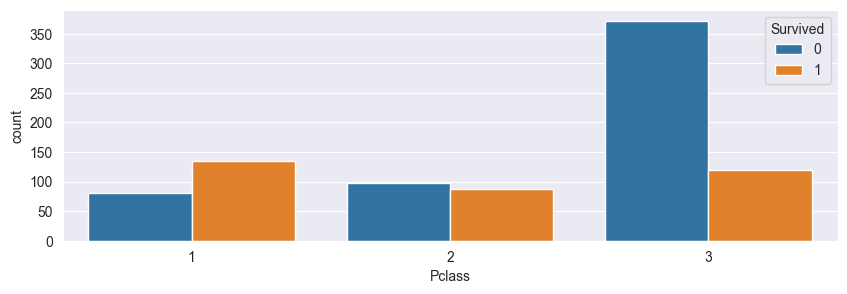

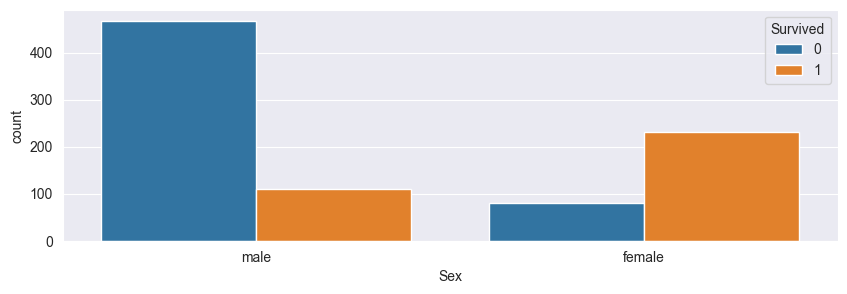

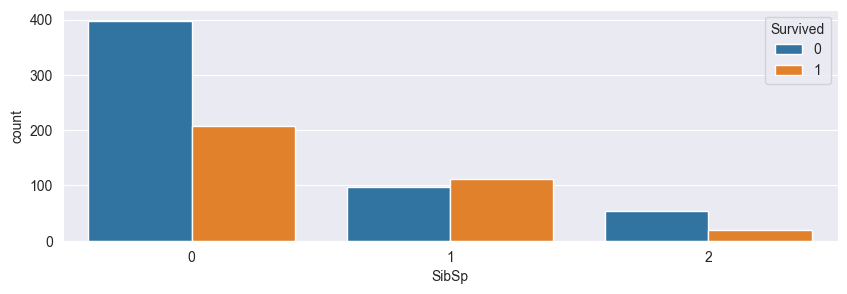

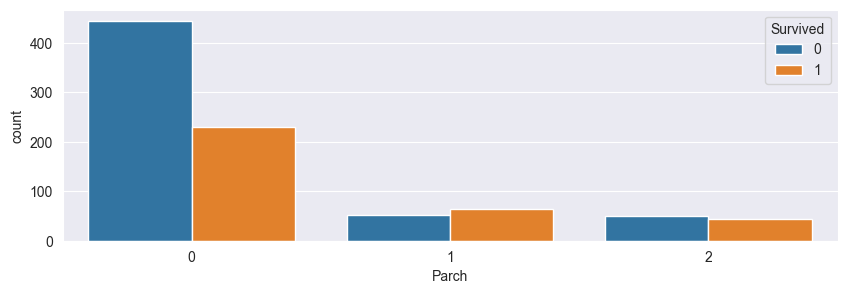

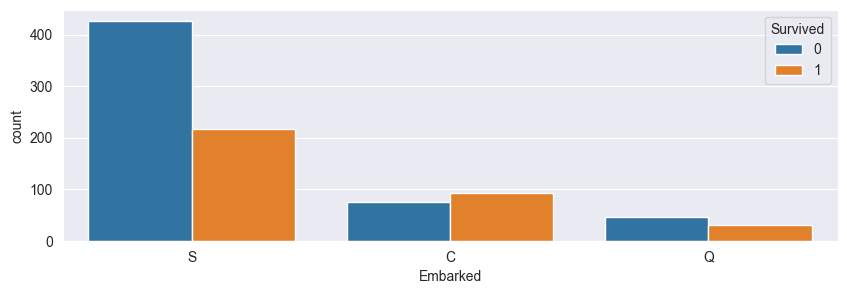

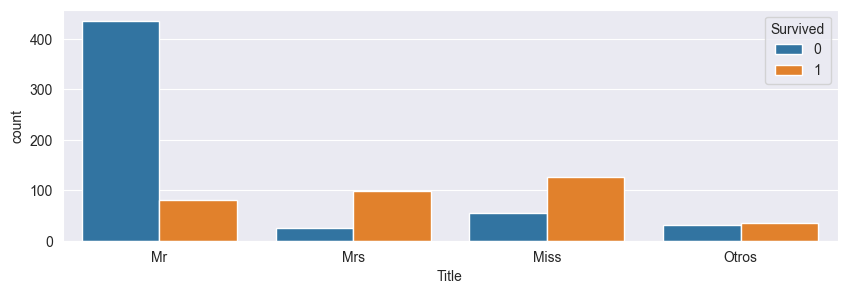

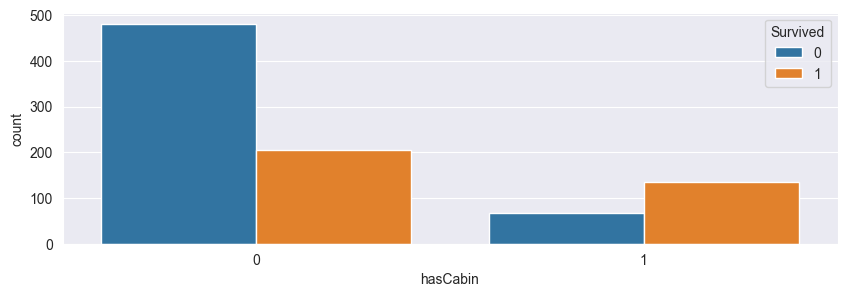

In [54]:
for col in cat_cols:
    plt.figure(figsize=(10,3))
    sns.countplot(data=df4, x=col, hue='Survived')
    plt.show()

# Categorical transformers

In [64]:
""" Label encoder """

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

X = df4.Title

labeler = LabelEncoder()
X_labeled = labeler.fit_transform(X)

# X[0:5]
# X_labeled[0:5]

labeler.inverse_transform([0,1,2,3])

array(['Miss', 'Mr', 'Mrs', 'Otros'], dtype=object)

(889, 10)


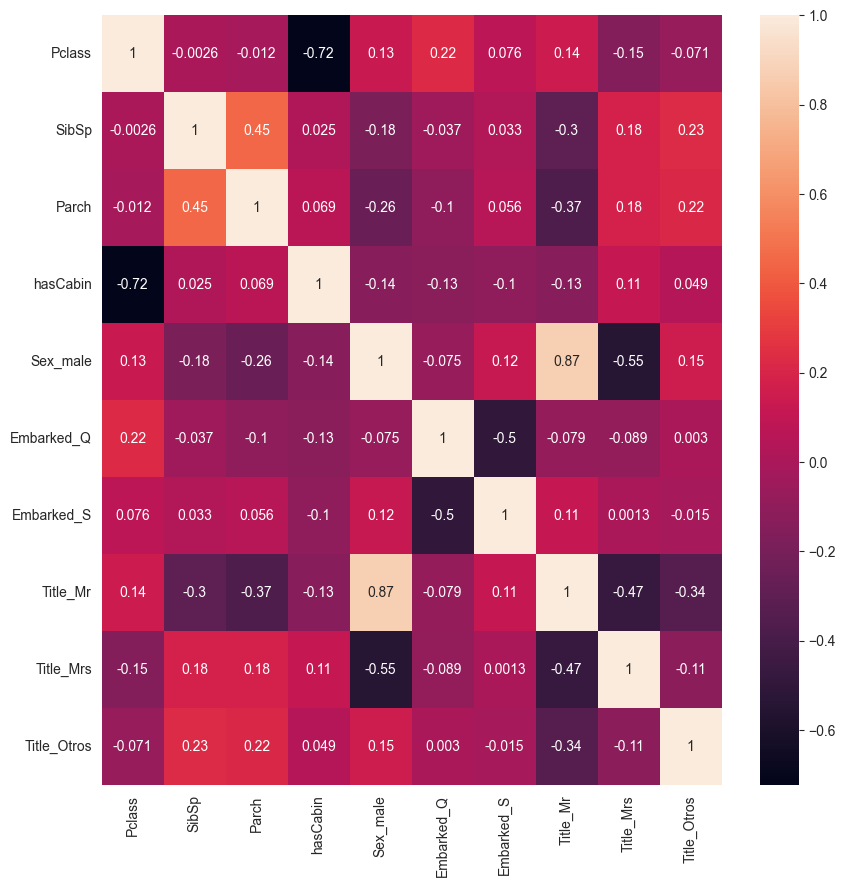

In [80]:
""" get_dummies de pandas """

df5 = df4.copy()

df5 = df5[cat_cols]
# df5.head()

df5 = pd.get_dummies(df5, drop_first='True')
print(df5.shape)

# model=LogisticRegression()
# model.fit(df5, y)
# model.score(df5, y)

plt.figure(figsize=(10,10))
sns.heatmap(df5.corr(), annot=True)
plt.show()

In [100]:
""" OHE """

# Sex
ohe_sex = OneHotEncoder(drop='if_binary')
X = df4[['Sex']]
X_ohe = ohe_sex.fit_transform(X)

# Embarked
ohe_embarked = OneHotEncoder(drop='first')
X = df4[['Embarked']]
X_ohe = ohe_embarked.fit_transform(X)

# Title
titles = [['Mr', 'Mrs', 'Miss']]
ohe_title = OneHotEncoder(categories=titles, handle_unknown='ignore')
X = df2[['Title']]
X_ohe = ohe_title.fit_transform(X)

# X_ohe[0:10].toarray()

In [118]:
"""  ColumnTransformer """

from sklearn.compose import ColumnTransformer

ctransformer = ColumnTransformer([
    ('imputer', KNNImputer(n_neighbors=5), ['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']),
    ('ohe1', OneHotEncoder(drop='if_binary'), ['Sex']),
    ('ohe2', OneHotEncoder(drop='first'), ['Embarked', 'Parch']),
    ('ohe3', OneHotEncoder(categories=titles, handle_unknown='ignore'), ['Title'])
], remainder='passthrough') # drop o passthrough

X = df4[cat_cols + num_cols]

X_transf = ctransformer.fit_transform(X)

print(X.shape)
print(X_transf.shape)
# ctransformer.feature_names_in_
# ctransformer.get_feature_names_out()

X_transf

(889, 9)
(889, 14)


array([[22.,  3.,  1., ...,  0.,  0.,  0.],
       [38.,  1.,  1., ...,  1.,  0.,  1.],
       [26.,  3.,  0., ...,  0.,  1.,  0.],
       ...,
       [ 0.,  3.,  1., ...,  0.,  1.,  0.],
       [26.,  1.,  0., ...,  0.,  0.,  1.],
       [32.,  3.,  0., ...,  0.,  0.,  0.]])

In [135]:
# Ejercicio
# train test split
# meter el columntransformer en un pipeline con LR
# probar modelo con passthrough y con drop
# matriz de confusion con train y test
# vigilar overfitting

X = df4[cat_cols+num_cols]
y = df4['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ctransformer = ColumnTransformer([
    ('imputer', KNNImputer(n_neighbors=5), ['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']),
    ('ohe1', OneHotEncoder(drop='if_binary'), ['Sex']),
    ('ohe2', OneHotEncoder(drop='first'), ['Embarked', 'Parch']),
    ('ohe3', OneHotEncoder(categories=titles, handle_unknown='ignore'), ['Title'])
], remainder='drop')

model = LogisticRegression()

pipeline = Pipeline([
    ('coltrans', ctransformer),
    ('lr', model)
])

pipeline.fit(X_train, y_train)

# ------------

r_train = pipeline.score(X_train, y_train)
r_test = pipeline.score(X_test, y_test)

print(r_train)
print(r_test)

0.8073136427566807
0.8539325842696629


In [138]:
# Ejercicio
# train test split
# meter el columntransformer en un pipeline con LR
# probar modelo con passthrough y con drop
# cv

X = df4[cat_cols+num_cols]
y = df4['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ctransformer = ColumnTransformer([
    ('imputer', KNNImputer(n_neighbors=5), ['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']),
    ('ohe1', OneHotEncoder(drop='if_binary'), ['Sex']),
    ('ohe2', OneHotEncoder(drop='first'), ['Embarked', 'Parch']),
    ('ohe3', OneHotEncoder(categories=titles, handle_unknown='ignore'), ['Title'])
], remainder='drop')

model = LogisticRegression()

pipeline = Pipeline([
    ('coltrans', ctransformer),
    ('lr', model)
])

r = cross_val_score(pipeline, X, y, cv=KFold(n_splits=10))
r.mean()

0.7997829417773238

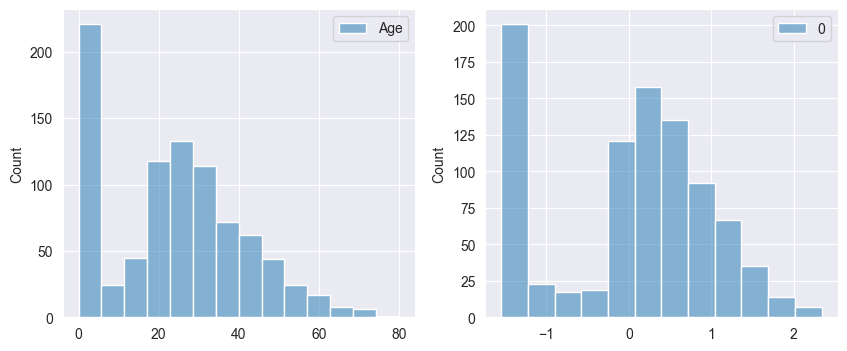

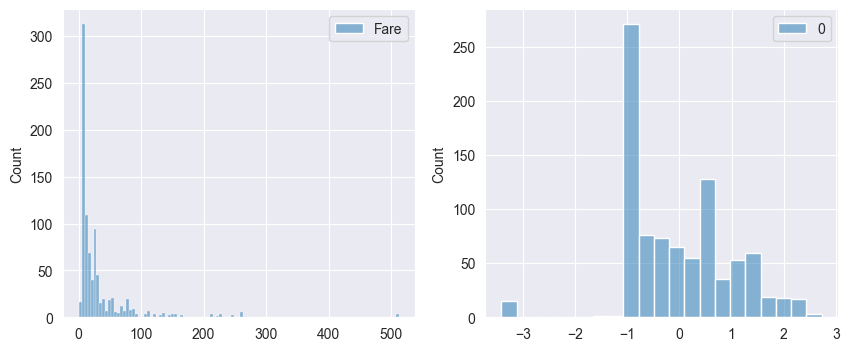

In [148]:
""" Features numericas """

from sklearn.preprocessing import RobustScaler, PowerTransformer

# pt = PowerTransformer(method='box-cox')
pt = PowerTransformer(method='yeo-johnson')
for col in num_cols:
    X = df4[[col]]
    X_new = pt.fit_transform(X+1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(X)
    plt.subplot(1,2,2)
    sns.histplot(X_new)
    plt.show()

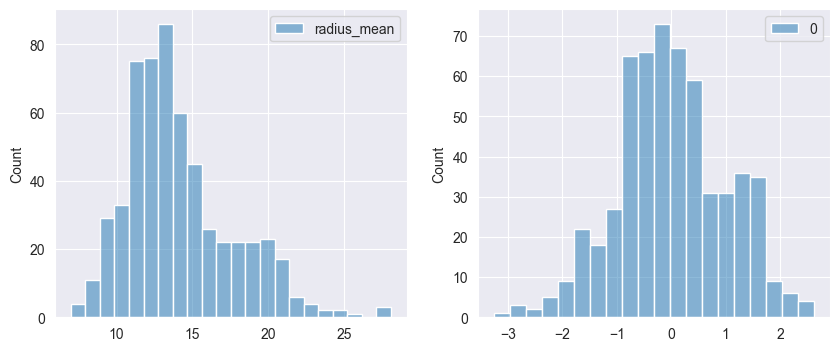

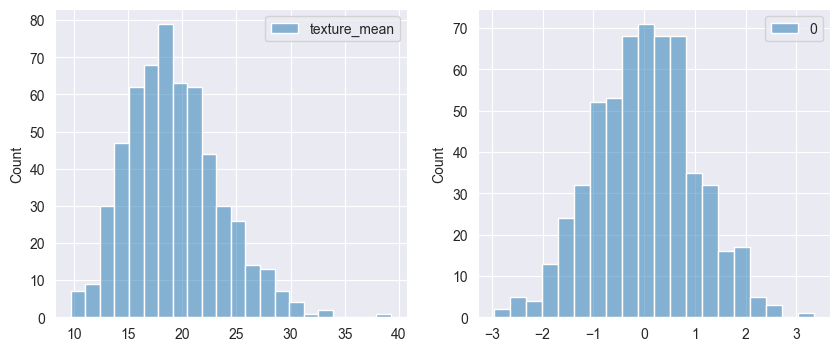

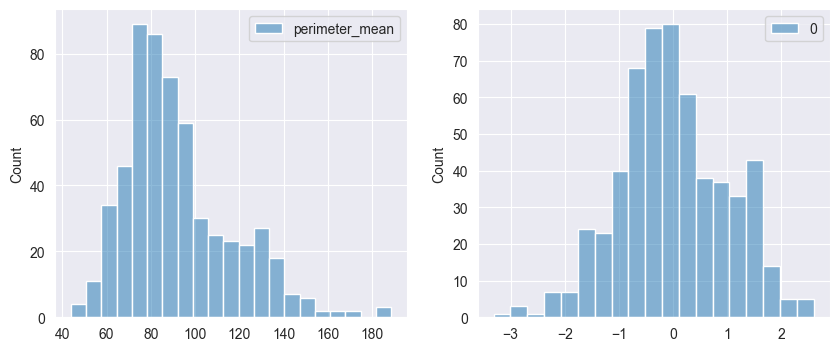

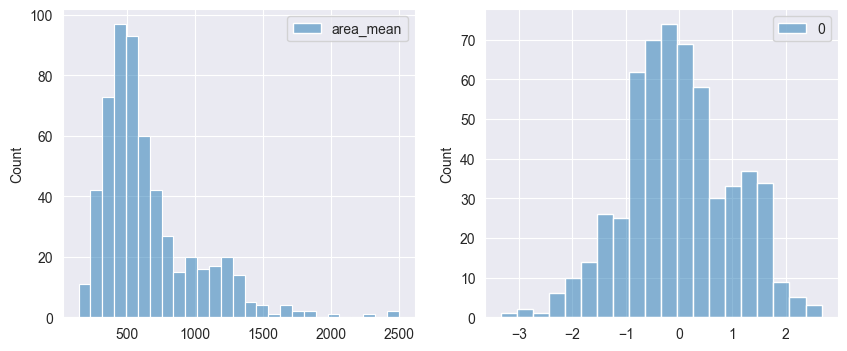

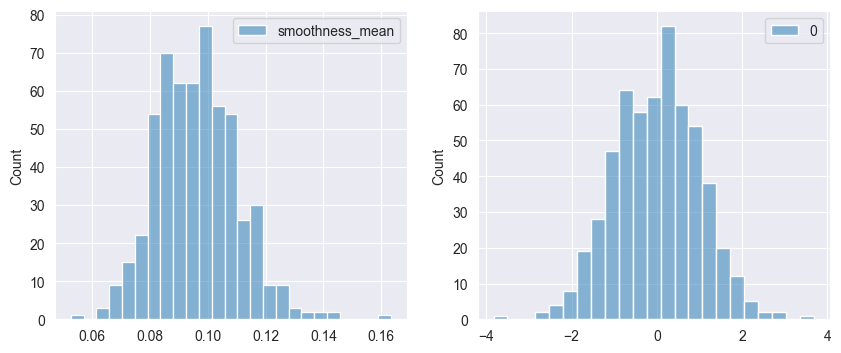

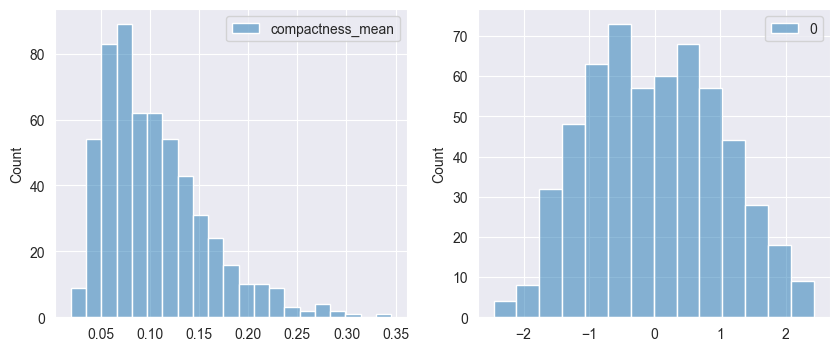

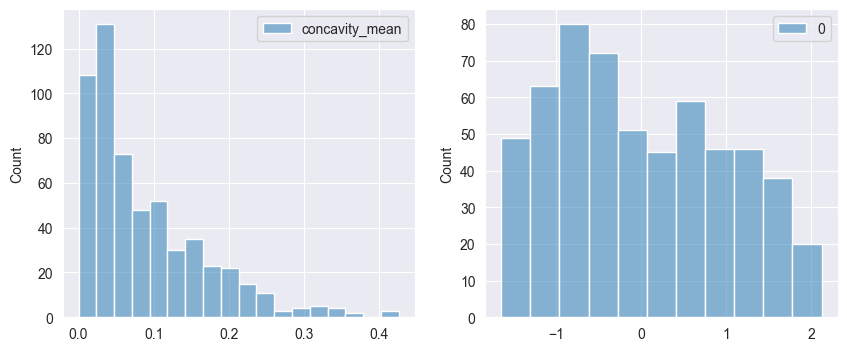

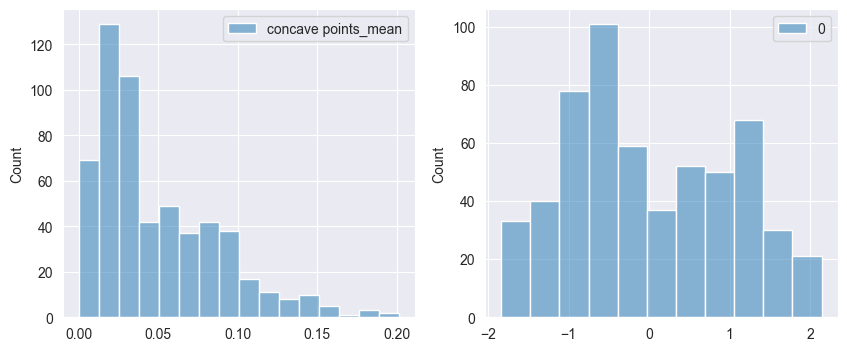

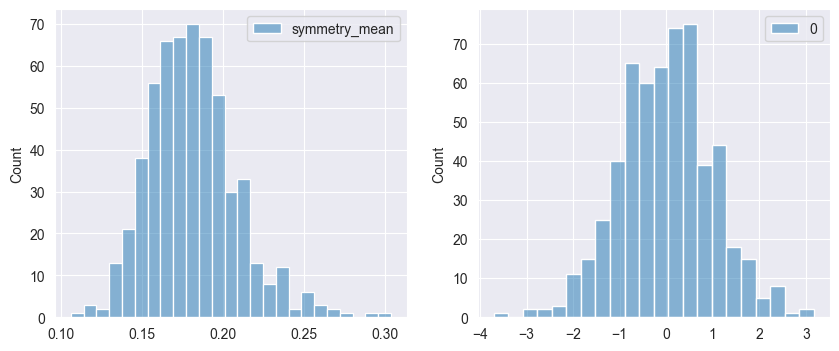

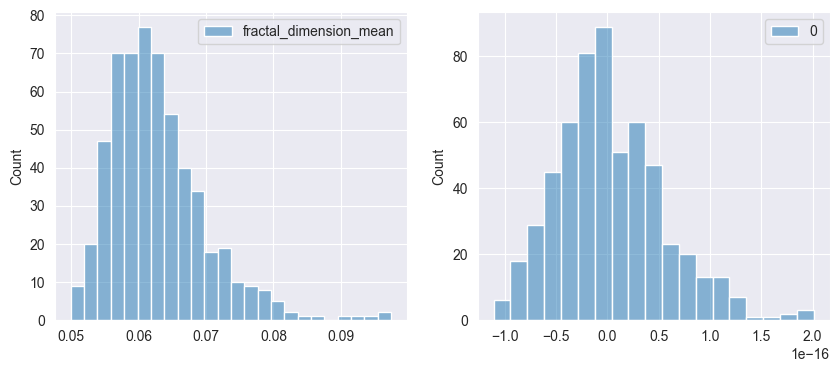

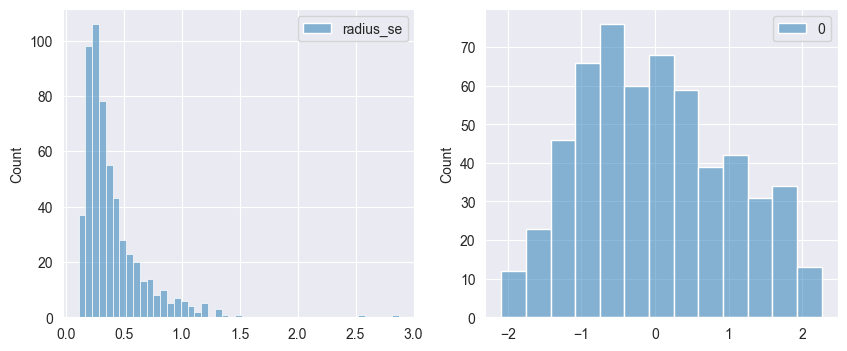

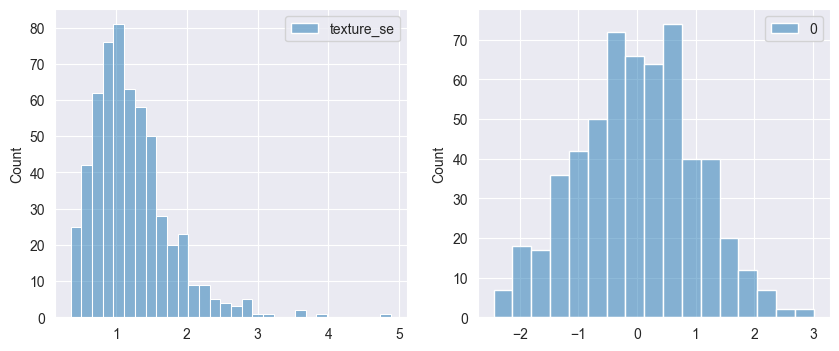

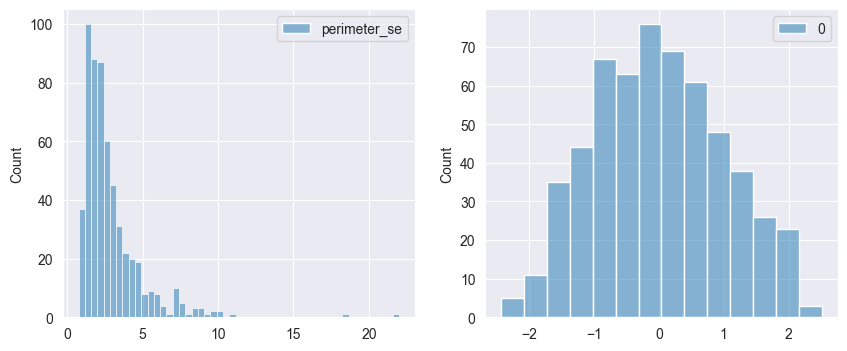

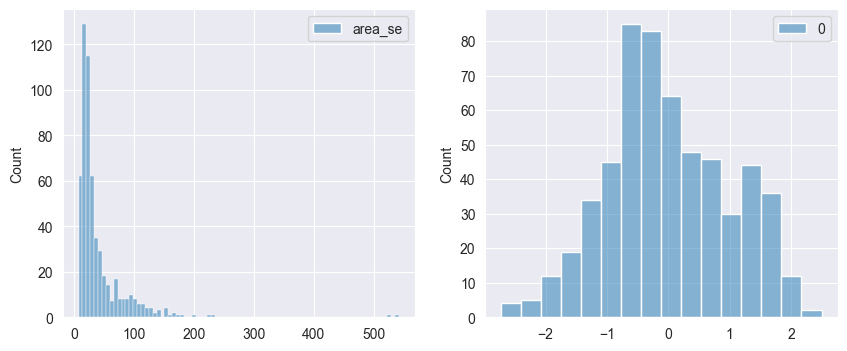

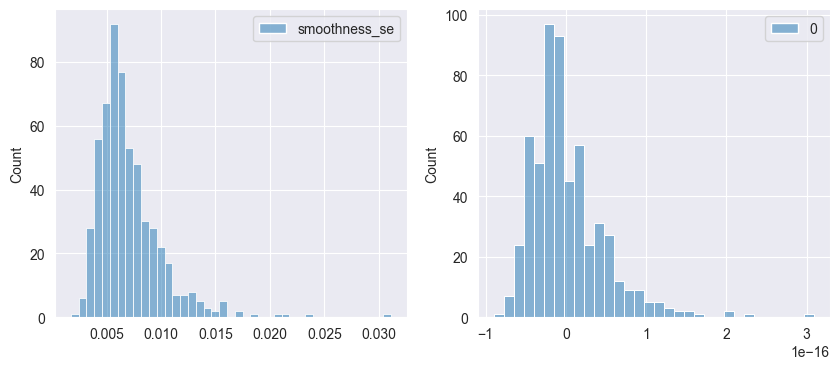

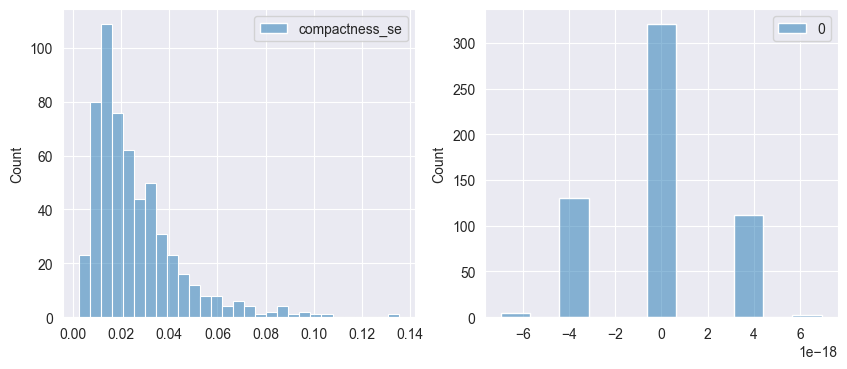

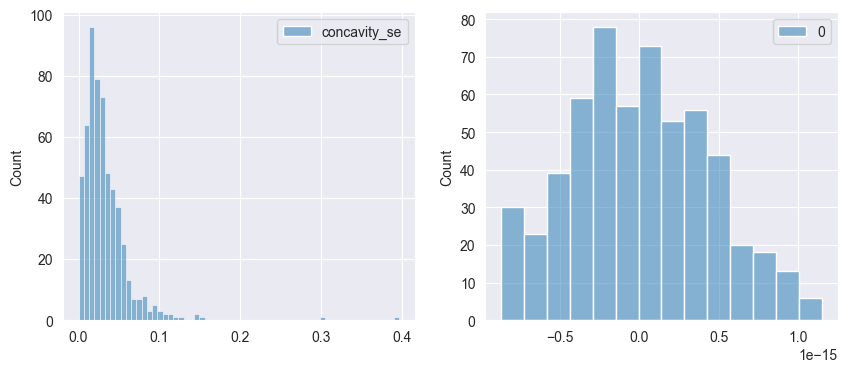

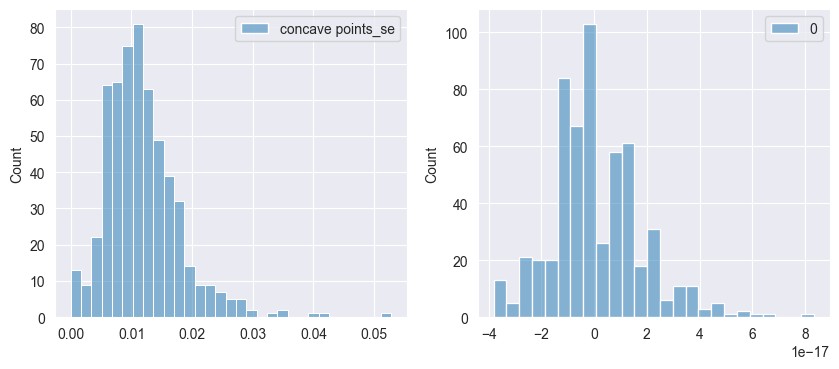

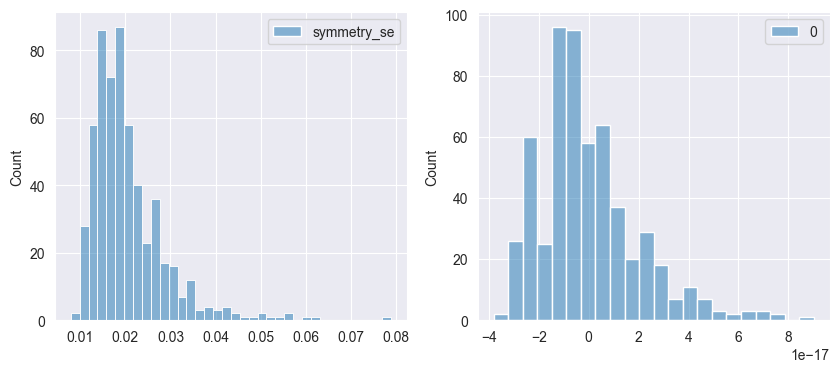

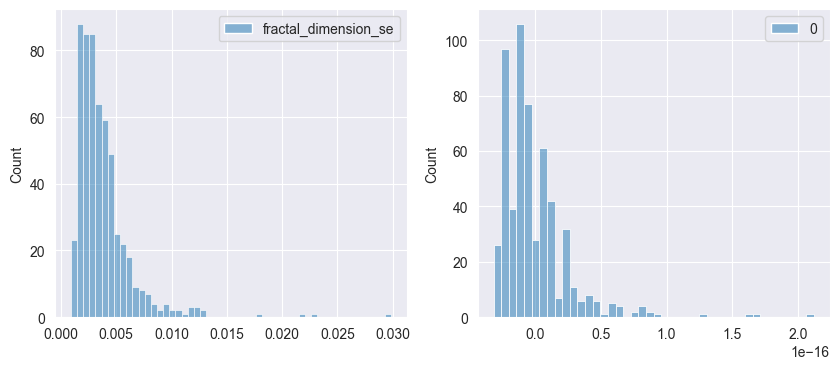

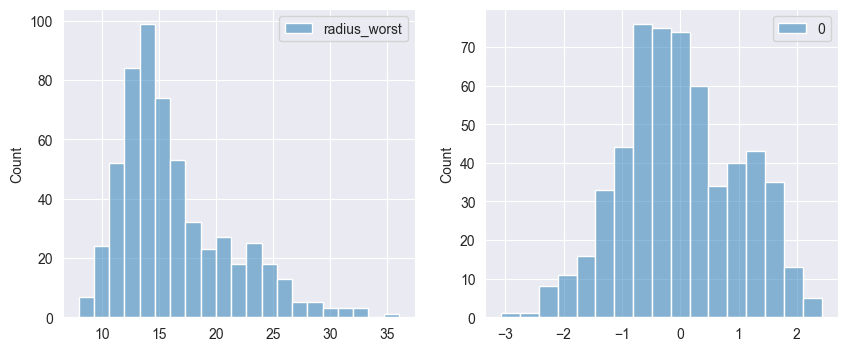

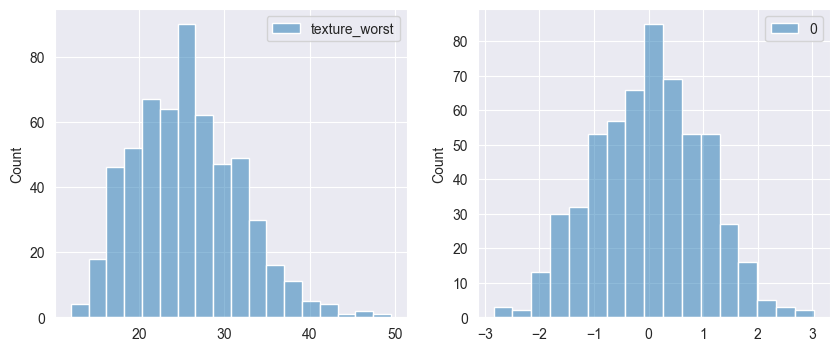

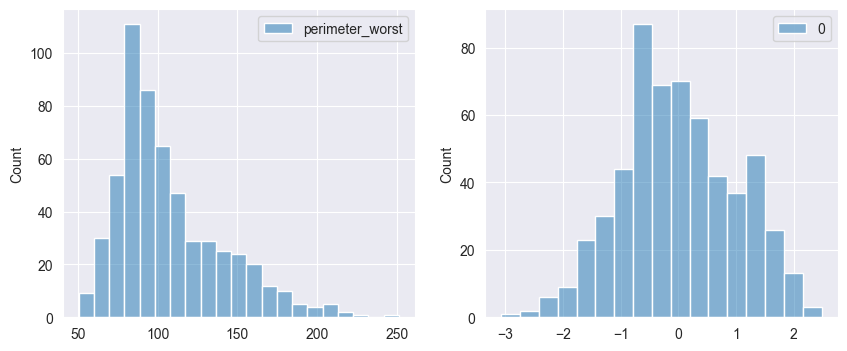

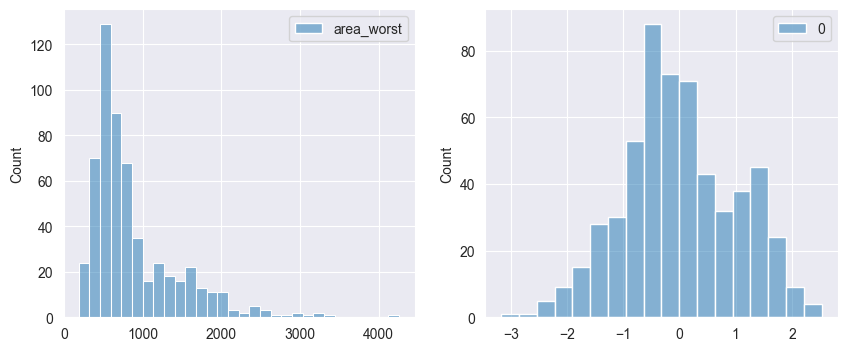

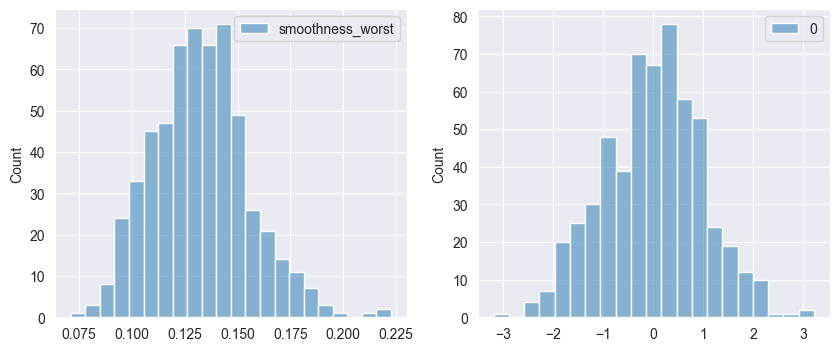

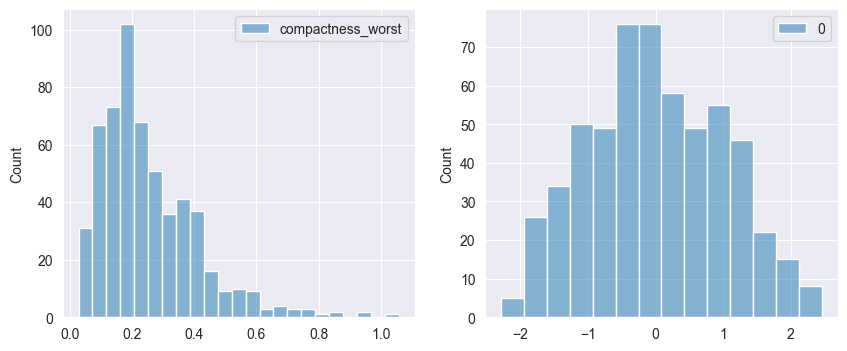

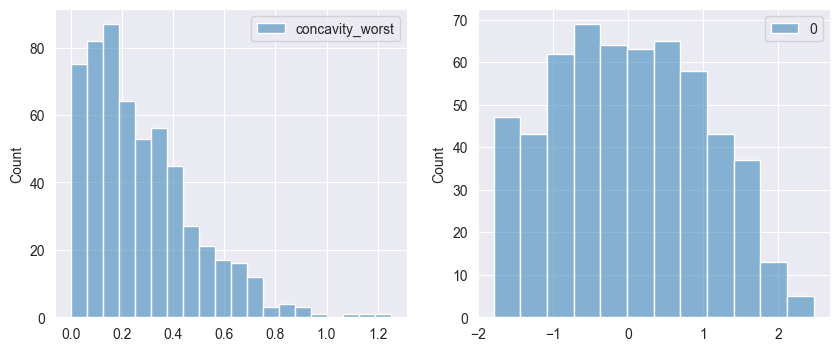

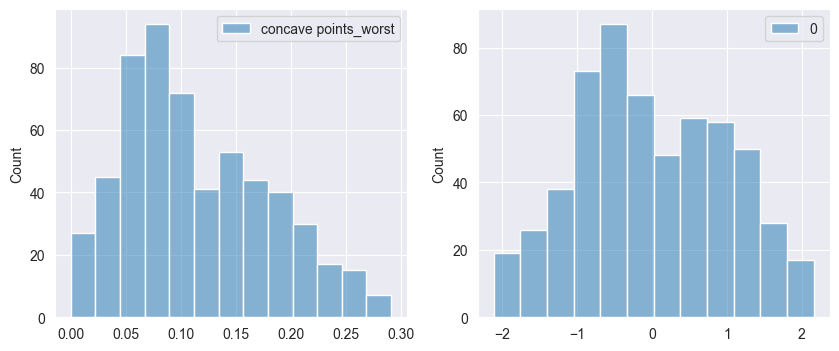

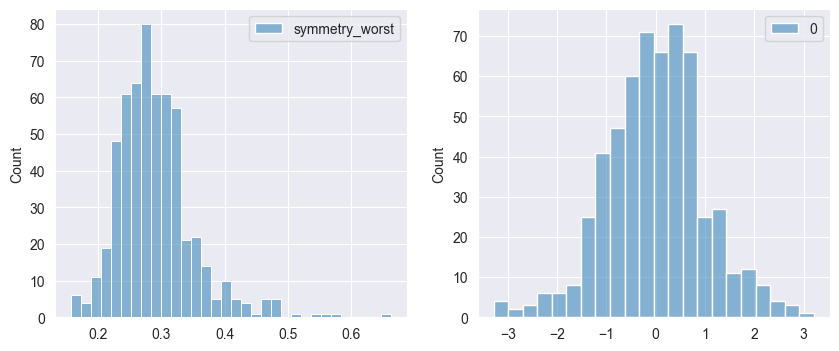

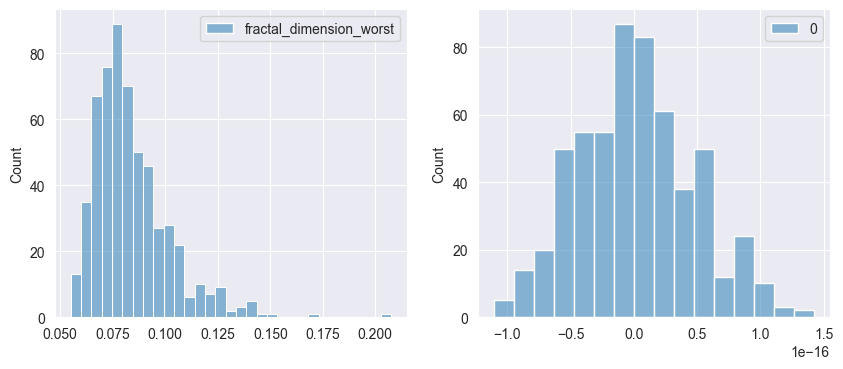

In [153]:
df_aux = pd.read_csv('breast_cancer_data.csv')
key_cols = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

pt = PowerTransformer(method='yeo-johnson')
for col in key_cols:
    X = df_aux[[col]]
    X_new = pt.fit_transform(X+1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(X)
    plt.subplot(1,2,2)
    sns.histplot(X_new)
    plt.show()

In [150]:
!dir

 El volumen de la unidad C no tiene etiqueta.
 El número de serie del volumen es: E2A7-D6D5

 Directorio de C:\Users\profesorfee\Desktop\mlpython

18/02/2023  13:29    <DIR>          .
18/02/2023  13:29    <DIR>          ..
18/02/2023  11:15    <DIR>          .ipynb_checkpoints
18/02/2023  08:52           124.635 breast_cancer_data.csv
18/02/2023  08:52             8.065 Tema1.ipynb
18/02/2023  11:14         3.674.458 Tema2.ipynb
18/02/2023  13:29           332.617 Tema3.ipynb
18/02/2023  08:57            65.367 titanic-2.csv
18/02/2023  11:15                72 Untitled.ipynb
               6 archivos      4.205.214 bytes
               3 dirs  158.896.627.712 bytes libres
